In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/result.csv', parse_dates=['time'], index_col=['time'])
data

,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
time,,,,,
2017-01-01 00:00:00,2.200,22.832449,0,25.000003,0.733767
2017-01-01 00:05:00,1.825,22.824465,0,25.000003,0.733767
2017-01-01 00:10:00,1.450,22.812760,0,25.000003,0.733767
2017-01-01 00:15:00,1.075,22.799019,0,25.000003,0.733767
2017-01-01 00:20:00,0.700,22.784421,0,25.000003,0.733767
...,...,...,...,...,...
2017-12-31 23:40:00,6.000,22.990503,0,25.000004,0.733767
2017-12-31 23:45:00,6.000,22.988552,0,25.000004,0.733767
2017-12-31 23:50:00,6.000,22.986715,0,25.000004,0.733767


In [3]:
train_data = data.loc['2017-07-04 07:30:00':'2017-07-04 09:30:00']
test_data = data.loc['2017-07-04 09:35:00':'2017-07-04 11:00:00']

# Data Visualization

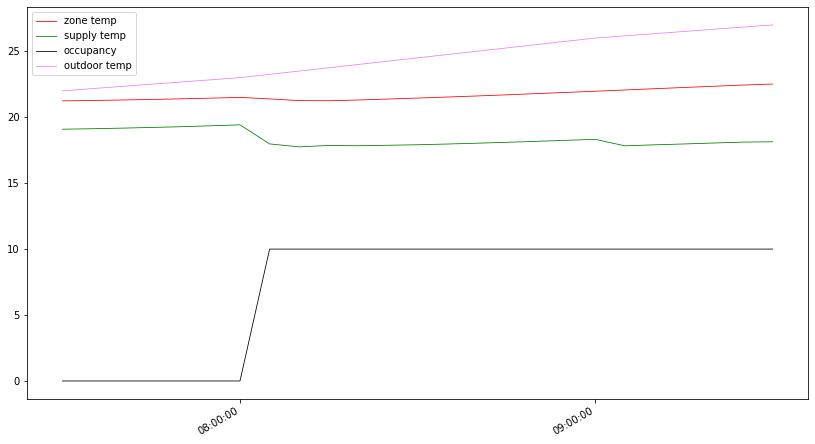

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(train_data.index, train_data['zone_temp'].values, color = 'red', linewidth = 0.8, label = 'zone temp')
ax.plot(train_data.index, train_data['supply_temp'].values, color = 'green', linewidth = 0.8, label = 'supply temp')
ax.plot(train_data.index, train_data['occupancy'].values, color = 'black', linewidth = 0.8, label = 'occupancy')
ax.plot(train_data.index, train_data['outdoor_temp'].values, color = 'violet', linewidth = 0.8, label = 'outdoor temp')
#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
plt.legend()
plt.show()

# Data Preprocessing

In [5]:
from sklearn.preprocessing import MinMaxScaler

x_train = train_data[['supply_temp', 'air_flow','outdoor_temp','occupancy']]
y_train = train_data[['zone_temp']]

x_test = test_data[['supply_temp', 'air_flow','outdoor_temp','occupancy']]
y_test = test_data[['zone_temp']]

scaler = MinMaxScaler().fit(x_train)

x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

# Linear Regression

In [6]:
import statsmodels.api as sm

model = sm.OLS(y_train, x_train_norm)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              zone_temp   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              1162.
Date:                Sun, 31 Jan 2021   Prob (F-statistic):                    2.28e-24
Time:                        10:49:22   Log-Likelihood:                         -48.982
No. Observations:                  25   AIC:                                      104.0
Df Residuals:                      22   BIC:                                      107.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            23.8234      0.814     29.261      0.000      22.135      25.512
x2            10.2269      0.631     16.209      0.000       8.918      11.535
x3            -3.4194      1.864     -1.834      0.080      -7.286       0.447
x4            10.2269      0.631     16.209      0.000       8.918      11.535
==============================================================================
Omnibus:                        1.343   Durbin-Watson:                   0.995
Prob(Omnibus):                  0.511   Jarque-Bera (JB):                0.963
Skew:                          -0.471   Prob(JB):                        0.618
Kurtosis:                       2.808   Cond. No.                     6.39e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.09e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [7]:
pred = results.predict(x_test_norm)
#print(pred)
#print(y_test)

In [8]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred)

14.122249316496053

In [9]:
bounds = y_test.copy()
bounds['pred'] = pred


# Actual values vs Predicted values (Linear Regression)

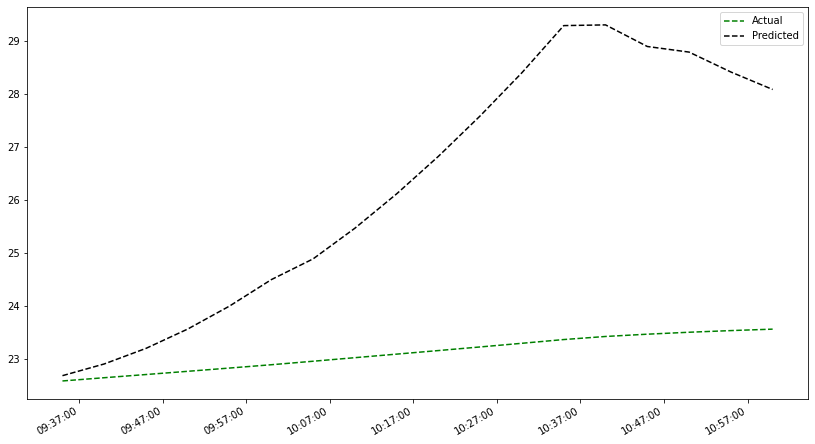

In [10]:
fig, ax = plt.subplots()
hours = mdates.MinuteLocator(interval = 10)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(bounds.index, bounds['zone_temp'].values, '--', color = 'green', label = 'Actual')
ax.plot(bounds.index, bounds['pred'].values, '--', color = 'black', label = 'Predicted')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
#plt.fill_between(bounds.index, bounds['upper'].values,bounds['lower'].values,color='cornflowerblue',alpha=.5)
plt.legend()
plt.show()

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(x_train_norm, y_train)
gpr.score(x_train_norm, y_train)

pred = gpr.predict(x_test_norm, return_std=True)
# print(pred)
# print(y_test)

In [12]:
mean_squared_error(y_test, pred[0])

0.051949598684757486

In [13]:
bounds = y_test.copy()
bounds['pred'] = pred[0]
bounds

,zone_temp,pred
time,,
2017-07-04 09:35:00,22.581924,22.428229
2017-07-04 09:40:00,22.643272,22.483465
2017-07-04 09:45:00,22.703502,22.538278
2017-07-04 09:50:00,22.764364,22.592681
2017-07-04 09:55:00,22.826025,22.646689
2017-07-04 10:00:00,22.888415,22.700318
2017-07-04 10:05:00,22.954525,22.754568
2017-07-04 10:10:00,23.021775,22.807737
2017-07-04 10:15:00,23.088946,22.860498


# Actual values vs Predicted values (Gaussain Process Regression)

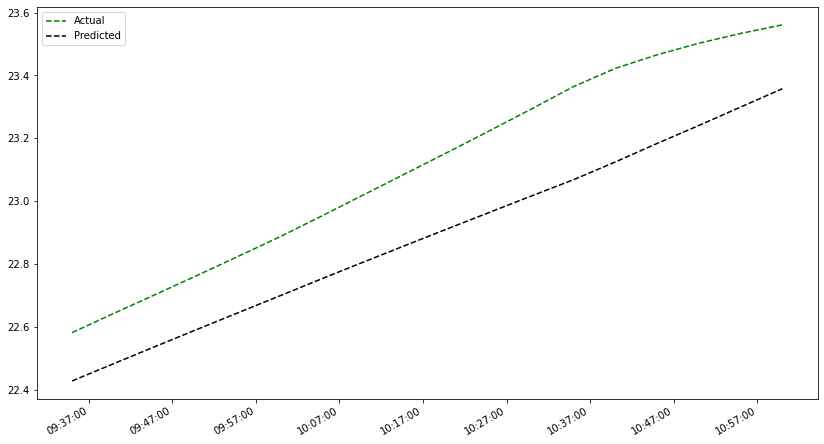

In [14]:
fig, ax = plt.subplots()
hours = mdates.MinuteLocator(interval = 10)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(bounds.index, bounds['zone_temp'].values, '--', color = 'green', label = 'Actual')
ax.plot(bounds.index, bounds['pred'].values, '--', color = 'black', label = 'Predicted')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
#plt.fill_between(bounds.index, bounds['upper'].values,bounds['lower'].values,color='cornflowerblue',alpha=.5)
plt.legend()
plt.show()

In [18]:

d = pd.read_csv('data/result.csv')
err = 100000
end_index = 2
while err < 0.1:
    zone_data = d[0:end_index]
    zone_data['time'] = pd.to_datetime(zone_data['time'], dayfirst=False)
    start_time = zone_data['time'][0]
    end_time = zone_data['time'][len(zone_data['time'])-1]
    train = data.loc['2017-07-04 07:30:00':'2017-07-04 07:40:00']
    test_data = data.loc['2017-07-04 09:35:00':'2017-07-04 09:45:00']
    x_train = train[['supply_temp', 'air_flow','outdoor_temp','occupancy']]
    y_train = train[['zone_temp']]

    scaler = MinMaxScaler().fit(x_train)

    x_train_norm = scaler.transform(x_train)  
    
#test_data = data.loc['2017-07-04 09:35:00':'2017-07-04 11:00:00']

<class 'pandas.core.frame.DataFrame'>
